<a href="https://colab.research.google.com/github/pycroscopy/AICrystallographer/blob/master/Tutorials/Dogs_vs_atoms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dogs versus Atoms: Fun Deep Learning

Created: 01/20/2019

Author: Maxim Ziatdinov

Email: ziatdinovmax@gmail.com

We will first need to download into VM storage a folder with the following files: image of a dog, experimental image of an atomic structure and imagenet labels.

In [0]:
%%bash
gdown https://drive.google.com/uc?id=1DVXZZTunBgJLJBLQa34gordxZdkAuTVr
unzip dogs_atoms_imagenet.zip > /dev/null

Downloading...
From: https://drive.google.com/uc?id=1DVXZZTunBgJLJBLQa34gordxZdkAuTVr
To: /content/dogs_atoms_imagenet.zip
100% 321k/321k [00:00<00:00, 48.0MB/s]


## Import/install modules

We next import necessary modules for working with neural networks. We are going to use tf.keras, which is the high level API for building neural networks with tensorflow. It simplifies a lot of of things in tensorflow and is perfect for the applied deep learning research.

In [0]:
# For working with neural networks
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model

In [0]:
# For data processing and plotting
import numpy as np
import matplotlib.pyplot as plt

## Load pretrained model

Load a trained VGG19 model. VGG-19 is a deep convolutional neural network trained on about million images from the ImageNet database. It consists of 19 convolutional layers and can classify images into 1000 categories, such as car, boat, mouse, pencil, and many animals (Reference: arXiv:1409.1556).

In [0]:
model = VGG19(weights='imagenet', include_top=True)

Instructions for updating:
Colocations handled automatically by placer.
574717952/574710816 [==============================] - 13s 0us/step


View model summary:

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Load ImageNet labels:
(you can get them from here https://gist.github.com/aaronpolhamus/964a4411c0906315deb9f4a3723aac57 )

In [0]:
labels = np.load('dogs_atoms_imagenet/imagenet_labels.npy', allow_pickle=True)[()]

## Deep learning with dogs

Load some fun image, e.g. your dog (or, in this case, my dog):

(-0.5, 223.5, 223.5, -0.5)

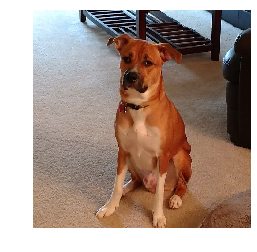

In [0]:
img_path = 'dogs_atoms_imagenet/Duffy.jpg'
img = image.load_img(
    img_path, target_size=(224, 224))
plt.imshow(img)
plt.axis('off')

Pre-process data such that it complies with tf/keras format:

In [0]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

Apply model to your image:

In [0]:
predictions = model.predict(x)

Let's see what the model has predicted (the predictions are very close!):

In [0]:
idx = (-predictions).argsort()[:,:3]
print('The top three predicitons are:\n')
for i_, i in enumerate(idx[0]):
    print(str(i_) + '.', labels[i], '('+str(predictions[:, i][0])+')', '\n')

The top three predicitons are:

0. Staffordshire bullterrier, Staffordshire bull terrier (0.4289909) 

1. American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier (0.2303331) 

2. basenji (0.11144482) 



Now let's visualize some feature maps from model internal layers (see model.summary() for names of different blocks/layers):

In [0]:
base_model = VGG19(weights='imagenet')
model_ = Model(inputs=base_model.input, outputs=base_model.get_layer('block3_conv4').output)
features = model_.predict(x)

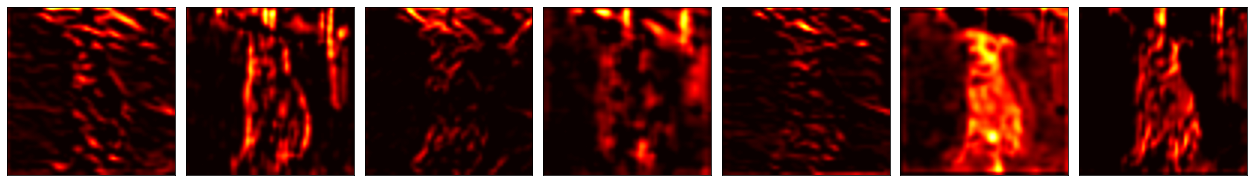

In [0]:
plt.figure(figsize=(20, 8))
n = 8
for i in range(1, n):
    ax = plt.subplot(1, n, i)
    plt.imshow(features[0,:,:,i+5], cmap = 'hot', Interpolation = 'Gaussian')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.tight_layout()

Using such visualizations, we can get an intuitive understanding of how the model "understood" that an object in the image was a dog of specific breed.

## Deep learning with atoms

Now let's do the same for experimental data collected in scanning transmission electron microscopy (STEM) experiment on graphene:

(the experimental data was collected by O. Dyck at ORNL)

(-0.5, 223.5, 223.5, -0.5)

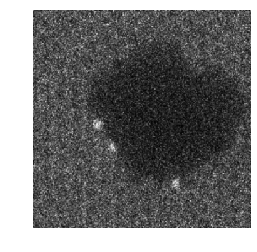

In [0]:
img_path = 'dogs_atoms_imagenet/Wobbly2-frame265.png'
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
plt.axis('off')

Now let's make predictions using the same model. As one can easily see, these predictions do not make much sense:

In [0]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

predictions = model.predict(x)
idx = (-predictions).argsort()[:,:3]
print('The top three predicitons are:\n')
for i_, i in enumerate(idx[0]):
    print(str(i_) + '.', labels[i], '('+str(predictions[:, i][0])+')', '\n')

The top three predicitons are:

0. doormat, welcome mat (0.1151126) 

1. poncho (0.051050495) 

2. wool, woolen, woollen (0.032442056) 



Even worse, the model apparently learn wrong features (it doesn't distinguish atoms):

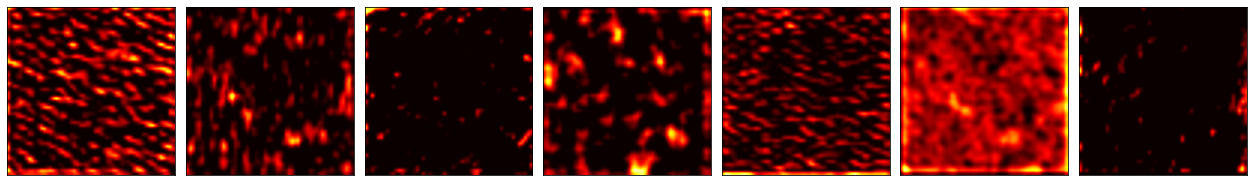

In [0]:
features = model_.predict(x)

plt.figure(figsize=(20, 8))
n = 8
for i in range(1, n):
    ax = plt.subplot(1, n, i)
    plt.imshow(features[0,:,:,i+5], cmap = 'hot', Interpolation = 'Gaussian')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.tight_layout()

And this is why we'll need to come up with our own training data (and even our own network, as we will discover later) to analyze the experimental data dominated by high levels of noise, etc.